## Polynomial Chaos Expansion example: Camel function (3 random inputs, scalar output)

Authors: Katiana Kontolati, Dimitrios Loukrezis \
Date: May 6, 2021

In this example, PCE is used to generate a surrogate model for a given set of 2D data.

### Six-hump camel function

<img src="Example_Camel_function.png" alt="Drawing" style="width: 400px;"/>

$$ f(\textbf{x}) = \Big(4-2.1x_1^2 + \frac{x_1^4}{3} \Big)x_1^2 + x_1x_2 + (-4 + 4x_2^2)x_2^2$$

**Description:**  Dimensions: 2

**Input Domain:**  This function is evaluated on the hypercube $x_1 \in [-3, 3], x_2 \in [-2, 2]$.

**Global minimum:** $f(\textbf{x}^*)=-1.0316,$ at $\textbf{x}^* = (0.0898, -0.7126)$ and $(-0.0898, 0.7126)$.

**Reference:**  Molga, M., & Smutnicki, C. Test functions for optimization needs (2005). Retrieved June 2013, from http://www.zsd.ict.pwr.wroc.pl/files/docs/functions.pdf.

Import necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from UQpy.Distributions import Uniform, JointInd
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from UQpy.Surrogates import *

Define the function.

In [2]:
def function(x,y):
    return (4-2.1*x**2 + x**4/3)*x**2 + x*y + (-4+4*y**2)*y**2

Create a distribution object, generate samples and evaluate the function at the samples.

In [3]:
np.random.seed(1)

dist_1 = Uniform(loc=-2, scale=4)    
dist_2 = Uniform(loc=-1, scale=2)    

marg = [dist_1, dist_2]
joint = JointInd(marginals=marg)

n_samples = 250
x = joint.rvs(n_samples)
y = function(x[:,0], x[:,1])  

Visualize the 2D function.

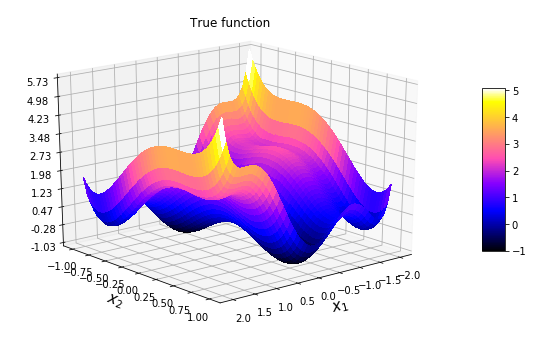

In [4]:
xmin, xmax = -2,2
ymin, ymax = -1,1
X1 = np.linspace(xmin, xmax, 50)
X2 = np.linspace(ymin, ymax, 50)
X1_, X2_ = np.meshgrid(X1, X2) # grid of points
f = function(X1_, X2_)

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X1_, X2_, f, rstride=1, cstride=1, cmap='gnuplot2', linewidth=0, antialiased=False)
ax.set_title('True function')
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20, 50)
fig.colorbar(surf, shrink=0.5, aspect=7)

plt.show()

Visualize training data.

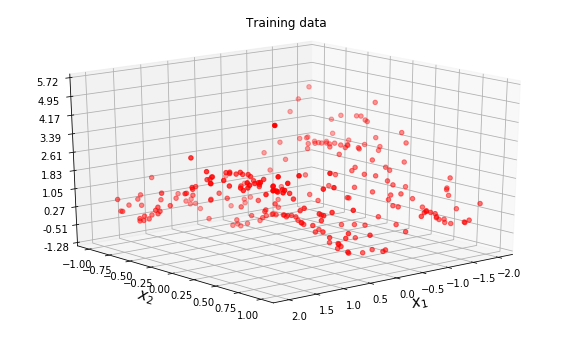

In [5]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(x[:,0], x[:,1], y, s=20, c='r')

ax.set_title('Training data')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20,50)
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
#ax.set_xlim(-10,10)
#ax.set_ylim(-6,6)
#ax.set_zlim(-1,1.5)
plt.show()

Decide on a maximum polynomial degree.

In [7]:
max_degree = 6

Compute a PCE using least squares regression.

In [8]:
pce = PolyChaosExp(joint)
construct_td_basis(pce, max_degree)
fit_lstsq(pce, x, y) 

Compute PCE using LASSO regression.

In [9]:
pce2 = PolyChaosExp(joint)
construct_td_basis(pce2, max_degree)
fit_lasso(pce2, x, y) 

Compute PCE using Ridge regression.

In [10]:
pce3 = PolyChaosExp(joint)
construct_td_basis(pce3, max_degree)
fit_ridge(pce3, x, y) 

PCE surrogate is used to predict the behavior of the function at new samples.

In [11]:
n_test_samples = 20000
x_test = joint.rvs(n_test_samples)
y_test = pce.predict(x_test)

Plot PCE prediction.

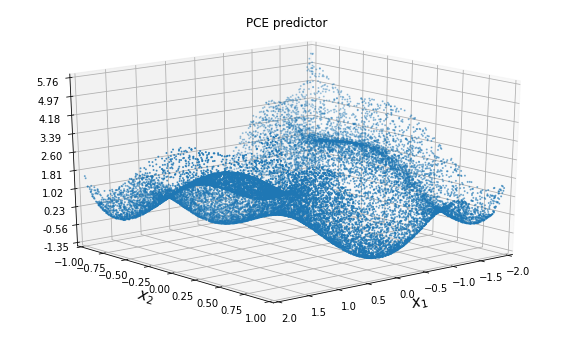

In [12]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(x_test[:,0], x_test[:,1], y_test, s=1)

ax.set_title('PCE predictor')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20,50)
ax.set_xlim(-2,2)
ax.set_ylim(-1,1)
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
#ax.set_zlim(0,136)
plt.show()

### Error Estimation

Validation error.

In [13]:
# validation sample
n_samples = 150
x_val = joint.rvs(n_samples)
y_val = function(x_val[:,0], x_val[:,1])

# PCE predictions
y_pce  = pce.predict(x_val).flatten()
y_pce2 = pce2.predict(x_val).flatten()
y_pce3 = pce3.predict(x_val).flatten()

# mean relative validation errors
error = np.sum(np.abs((y_val - y_pce)/y_val))/n_samples
error2 = np.sum(np.abs((y_val - y_pce2)/y_val))/n_samples
error3 = np.sum(np.abs((y_val - y_pce3)/y_val))/n_samples

print('Mean rel. error, LSTSQ:', error)
print('Mean rel. error, LASSO:', error2)
print('Mean rel. error, Ridge:', error3)

Mean rel. error, LSTSQ: 6.720300351777325e-15
Mean rel. error, LASSO: 0.013733318222446987
Mean rel. error, Ridge: 0.01399966972099546


### Moment Estimation

Returns mean and variance of the PCE surrogate.

In [14]:
n_mc = 1000000
x_mc = joint.rvs(n_mc)
y_mc = function(x_mc[:,0], x_mc[:,1])    
mean_mc = np.mean(y_mc)
var_mc = np.var(y_mc)

print('Moments from least squares regression :', pce_mean(pce), pce_variance(pce))
print('Moments from LASSO regression :', pce_mean(pce2), pce_variance(pce2))
print('Moments from Ridge regression :', pce_mean(pce3), pce_variance(pce3))
print('Moments from Monte Carlo integration: ', mean_mc, var_mc)

Moments from least squares regression : [1.12761905] [1.38071253]
Moments from LASSO regression : [1.12667733] [1.37022523]
Moments from Ridge regression : [1.12658297] [1.36805971]
Moments from Monte Carlo integration:  1.1275273163321682 1.3805224979467277
